In [1]:
import nltk
import sys
import re
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#Read train data from files into 4 vocabularies - one per emotion

anger = {}
with open(".\EI-reg-En-train\EI-reg-En-anger-train.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        anger[key] = float(val)
        
fear = {}
with open(".\EI-reg-En-train\EI-reg-En-fear-train.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        fear[key] = float(val)
        
joy = {}
with open(".\EI-reg-En-train\EI-reg-En-joy-train.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        joy[key] = float(val)
        
sadness = {}
with open(".\EI-reg-En-train\EI-reg-En-sadness-train.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        sadness[key] = float(val)

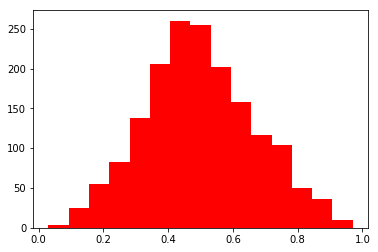

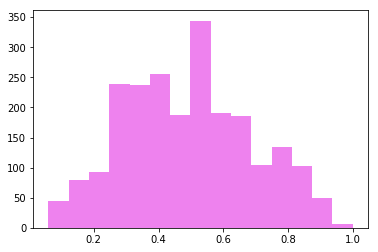

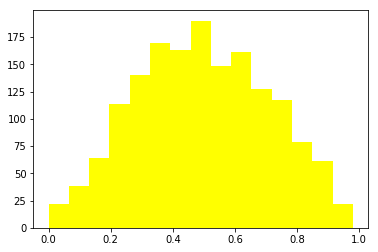

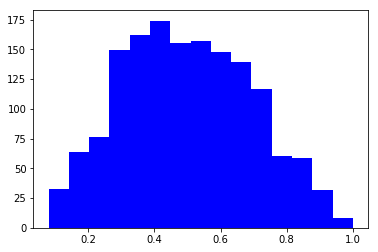

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist([anger[k] for k in anger.keys()], bins=15, color='red')
plt.show()

plt.hist([fear[k] for k in fear.keys()], bins=15, color='violet')
plt.show()

plt.hist([joy[k] for k in joy.keys()], bins=15, color='yellow')
plt.show()

plt.hist([sadness[k] for k in sadness.keys()], bins=15, color='blue')
plt.show()

In [14]:
#Read dev data from files into 4 vocabularies - one per emotion

anger_dev = {}
with open(".\EI-reg-En-dev\EI-reg-En-anger-dev.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        anger_dev[key] = float(val)
        
fear_dev = {}
with open(".\EI-reg-En-dev\EI-reg-En-fear-dev.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        fear_dev[key] = float(val)
        
joy_dev = {}
with open(".\EI-reg-En-dev\EI-reg-En-joy-dev.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        joy_dev[key] = float(val)
        
sadness_dev = {}
with open(".\EI-reg-En-dev\EI-reg-En-sadness-dev.txt", encoding="utf8") as f:
    for line in f:
        (idn, key, emotion, val) = line.split("\t", 4)
        val = val[:len(val)-2]
        sadness_dev[key] = float(val)

In [20]:
#Data tokenization

def tokenize(s):
        return tokens_re.findall(s)

def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        for token in tokens:
            if emoticon_re.search(token):
                tokens.append(token)
            else:
                tokens.append(token.lower())
    return tokens

emoticons_str = r"""
    (?:
        [:=;] 
        [oO\-]? 
        [D\)\]\(\]/\\OpP] 
    )"""
regex_str = [
    emoticons_str, # old-style emojis
    r'<[^>]+>', # HTML-tags
    r'(?:@[\w_]+)', # @-mentions of other users
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and ' symbols
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # other symbols
]

#if data with emojis will give bad result, we could skip emojis using this pattern
#emoji_pattern = re.compile("["
#        u"\U0001F600-\U0001F64F"  # emoticons
#        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#        u"\U0001F680-\U0001F6FF"  # transport & map symbols
#        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                           "]+", flags=re.UNICODE)

marks = ['.', ',', '-', '/', '…', '’', '—', '\\', '\'', '\"', '!', '!!', '@', '%', '^', '?', '&', '*', '(', ')', '_', 'n', '#', '+', '=', ';', ':', '$', '£', '\`', '~', '<', '>', ':)', ';)']

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def filter_dict(d, tokens, indexes):
    for k in d.keys():
        k = preprocess(k)
        new_key = []
        for i in k:
            if i not in stop_words and i not in marks:
                i = re.sub(r'(?:@[\w_]+)', "", i) # delete @-mentions
                i = re.sub(r'<[^>]+>', "", i) # delete HTML tags
                i = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', "", i) # delete URLs
                i = re.sub(r'(?:(?:\d+,?)+(?:\.?\d+)?)', "", i) # delete numbers
                #i = emoji_pattern.sub(r'', i) # delete new emojis
                #i = re.sub(emoticons_str, '', i) # delete old emoticons
                if len(i) > 1 and i[0] == '#':
                    i = i[1:]
                if i is not '':
                    new_key.append(i)            
        tokens.append(new_key)        
    for v in d.values():
        indexes.append(v)

#For train data        
anger_tokens = []
anger_ind = []
filter_dict(anger, anger_tokens, anger_ind)
fear_tokens = []
fear_ind = []
filter_dict(fear, fear_tokens, fear_ind)
joy_tokens = []
joy_ind = []
filter_dict(joy, joy_tokens, joy_ind)
sadness_tokens = []
sadness_ind = []
filter_dict(sadness, sadness_tokens, sadness_ind)

#For dev data
anger_tokens_dev = []
anger_ind_dev = []
filter_dict(anger_dev, anger_tokens_dev, anger_ind_dev)
fear_tokens_dev = []
fear_ind_dev = []
filter_dict(fear_dev, fear_tokens_dev, fear_ind_dev)
joy_tokens_dev = []
joy_ind_dev = []
filter_dict(joy_dev, joy_tokens_dev, joy_ind_dev)
sadness_tokens_dev = []
sadness_ind_dev = []
filter_dict(sadness_dev, sadness_tokens_dev, sadness_ind_dev)

In [ ]:
import gensim.models
Vec = gensim.models.KeyedVectors.load_word2vec_format('.\GoogleNews-vectors-negative300.bin\\GoogleNews-vectors-negative300.bin', binary=True)
model = Vec.wv
del Vec

In [6]:
def get_feat(data):
    feat = []
    for i in range(len(data)):
        f = []
        dat = data[i] # (data[i]).split(" ")
        temp = []
        for w in dat:
            if w in model:
                temp.append(model[w])
        if len(temp) == 0:
            temp.append(model['cat'])
        f = list(((np.array(temp)).mean(0)))
        f += list((np.median((np.array(temp)), 0)))
        f += list((np.array(temp)).max(0))
        f += list((np.array(temp)).min(0))
        f += list((np.percentile(temp, 25, 0)))
        f += list((np.percentile(temp, 75, 0)))
        n = [len(k) for k in dat]
        f.append(len(dat))
        f.append(sum(n))
        f.append(sum(n) / len(dat))
        feat.append(f)
    feat = np.array(feat)
    feat = np.reshape(feat, (len(data), 1803))
    return feat

In [7]:
#Feature extracting process

#For train data
anger_dicts, anger_indexes = get_feat(anger_tokens), anger_ind
fear_dicts, fear_indexes = get_feat(fear_tokens), fear_ind
joy_dicts, joy_indexes = get_feat(joy_tokens), joy_ind
sadness_dicts, sadness_indexes = get_feat(sadness_tokens), sadness_ind

#For dev data
anger_dicts_dev, anger_indexes_dev = get_feat(anger_tokens_dev), anger_ind_dev
fear_dicts_dev, fear_indexes_dev = get_feat(fear_tokens_dev), fear_ind_dev
joy_dicts_dev, joy_indexes_dev = get_feat(joy_tokens_dev), joy_ind_dev
sadness_dicts_dev, sadness_indexes_dev = get_feat(sadness_tokens_dev), sadness_ind_dev

train_anger = anger_dicts
dev_anger = anger_dicts_dev
train_fear = fear_dicts
dev_fear = fear_dicts_dev
train_joy = joy_dicts
dev_joy = joy_dicts_dev
train_sadness = sadness_dicts
dev_sadness = sadness_dicts_dev

In [111]:
#SVM model with rbf kernel

def model_svm_rbf(trainX, trainY, devX, devY, c):
    model = SVR(kernel='rbf', C=c, gamma=0.1)
    model.fit(trainX, trainY)
    train_predict = model.predict(devX)
    train_acc = np.linalg.norm(train_predict - devY) / len(train_predict)  
    return train_acc
 
c_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]
accuracy_anger_svm = []
accuracy_fear_svm = []
accuracy_joy_svm = []
accuracy_sadness_svm = []
for c in c_values:
    acc_anger = model_svm_rbf(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
    accuracy_anger_svm.append(acc_anger)
    print("SVR with RBF kernel: dev set RMSE for anger is %.4f" % acc_anger, "while c is %.2f" % c)
    acc_fear = model_svm_rbf(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
    accuracy_fear_svm.append(acc_fear)
    print("SVR with RBF kernel: dev set RMSE for fear is %.4f" % acc_fear, "while c is %.2f" % c)
    acc_joy = model_svm_rbf(train_joy, joy_indexes, dev_joy, joy_indexes_dev, c)
    accuracy_joy_svm.append(acc_joy)
    print("SVR with RBF kernel: dev set RMSE for joy is %.4f" % acc_joy, "while c is %.2f" % c)
    acc_sadness = model_svm_rbf(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
    accuracy_sadness_svm.append(acc_sadness)
    print("SVR with RBF kernel: dev set RMSE for sadness is %.4f" % acc_sadness, "while c is %.2f" % c)

SVR with RBF kernel: dev set RMSE for anger is 0.0100 while c is 0.01
SVR with RBF kernel: dev set RMSE for fear is 0.0090 while c is 0.01
SVR with RBF kernel: dev set RMSE for joy is 0.0110 while c is 0.01
SVR with RBF kernel: dev set RMSE for sadness is 0.0093 while c is 0.01
SVR with RBF kernel: dev set RMSE for anger is 0.0100 while c is 0.02
SVR with RBF kernel: dev set RMSE for fear is 0.0090 while c is 0.02
SVR with RBF kernel: dev set RMSE for joy is 0.0110 while c is 0.02
SVR with RBF kernel: dev set RMSE for sadness is 0.0093 while c is 0.02
SVR with RBF kernel: dev set RMSE for anger is 0.0099 while c is 0.05
SVR with RBF kernel: dev set RMSE for fear is 0.0089 while c is 0.05
SVR with RBF kernel: dev set RMSE for joy is 0.0110 while c is 0.05
SVR with RBF kernel: dev set RMSE for sadness is 0.0093 while c is 0.05
SVR with RBF kernel: dev set RMSE for anger is 0.0098 while c is 0.10
SVR with RBF kernel: dev set RMSE for fear is 0.0088 while c is 0.10
SVR with RBF kernel: dev

In [112]:
#SVM model with linear kernel

def model_svm_lin(trainX, trainY, devX, devY, c):
    model = SVR(kernel = 'linear', C = c)
    model.fit(trainX, trainY)
    train_predict = model.predict(devX)
    train_acc = np.linalg.norm(train_predict - devY) / len(train_predict)  
    return train_acc
 
c_values = [0.01, 0.1, 1, 10]
accuracy_anger_svm = []
accuracy_fear_svm = []
accuracy_joy_svm = []
accuracy_sadness_svm = []
for c in c_values:
    acc_anger = model_svm_lin(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
    accuracy_anger_svm.append(acc_anger)
    print("SVR with linear kernel: dev set RMSE for anger is %.4f" % acc_anger, "while c is %.2f" % c)
    acc_fear = model_svm_lin(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
    accuracy_fear_svm.append(acc_fear)
    print("SVR with linear kernel: dev set RMSE for fear is %.4f" % acc_fear, "while c is %.2f" % c)
    acc_joy = model_svm_lin(train_joy, joy_indexes, dev_joy, joy_indexes_dev, c)
    accuracy_joy_svm.append(acc_joy)
    print("SVR with linear kernel: dev set RMSE for joy is %.4f" % acc_joy, "while c is %.2f" % c)
    acc_sadness = model_svm_lin(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
    accuracy_sadness_svm.append(acc_sadness)
    print("SVR with linear kernel: dev set RMSE for sadness is %.4f" % acc_sadness, "while c is %.2f" % c)

SVR with linear kernel: dev set RMSE for anger is 0.0088 while c is 0.01
SVR with linear kernel: dev set RMSE for fear is 0.0079 while c is 0.01
SVR with linear kernel: dev set RMSE for joy is 0.0103 while c is 0.01
SVR with linear kernel: dev set RMSE for sadness is 0.0084 while c is 0.01
SVR with linear kernel: dev set RMSE for anger is 0.0100 while c is 0.10
SVR with linear kernel: dev set RMSE for fear is 0.0092 while c is 0.10
SVR with linear kernel: dev set RMSE for joy is 0.0118 while c is 0.10
SVR with linear kernel: dev set RMSE for sadness is 0.0096 while c is 0.10
SVR with linear kernel: dev set RMSE for anger is 0.0116 while c is 1.00
SVR with linear kernel: dev set RMSE for fear is 0.0125 while c is 1.00
SVR with linear kernel: dev set RMSE for joy is 0.0134 while c is 1.00
SVR with linear kernel: dev set RMSE for sadness is 0.0110 while c is 1.00
SVR with linear kernel: dev set RMSE for anger is 0.0156 while c is 10.00
SVR with linear kernel: dev set RMSE for fear is 0.01

In [113]:
#SVM model with poly kernel

def model_svm_poly(trainX, trainY, devX, devY, c):
    model = SVR(kernel='poly', C = c, degree = 2)
    model.fit(trainX, trainY)
    train_predict = model.predict(devX)
    train_acc = np.linalg.norm(train_predict - devY) / len(train_predict)  
    return train_acc
 
c_values = [0.01, 0.1, 1, 10]
accuracy_anger_svm = []
accuracy_fear_svm = []
accuracy_joy_svm = []
accuracy_sadness_svm = []
for c in c_values:
    acc_anger = model_svm_poly(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
    accuracy_anger_svm.append(acc_anger)
    print("SVR with polynomial kernel: dev set RMSE for anger is %.4f" % acc_anger, "while c is %.2f" % c)
    acc_fear = model_svm_poly(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
    accuracy_fear_svm.append(acc_fear)
    print("SVR with polynomial kernel: dev set RMSE for fear is %.4f" % acc_fear, "while c is %.2f" % c)
    acc_joy = model_svm_poly(train_joy, joy_indexes, dev_joy, joy_indexes_dev, c)
    accuracy_joy_svm.append(acc_joy)
    print("SVR with polynomial kernel: dev set RMSE for joy is %.4f" % acc_joy, "while c is %.2f" % c)
    acc_sadness = model_svm_poly(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
    accuracy_sadness_svm.append(acc_sadness)
    print("SVR with polynomial kernel: dev set RMSE for sadness is %.4f" % acc_sadness, "while c is %.2f" % c)

SVR with polynomial kernel: dev set RMSE for anger is 0.0100 while c is 0.01
SVR with polynomial kernel: dev set RMSE for fear is 0.0089 while c is 0.01
SVR with polynomial kernel: dev set RMSE for joy is 0.0109 while c is 0.01
SVR with polynomial kernel: dev set RMSE for sadness is 0.0092 while c is 0.01
SVR with polynomial kernel: dev set RMSE for anger is 0.0097 while c is 0.10
SVR with polynomial kernel: dev set RMSE for fear is 0.0085 while c is 0.10
SVR with polynomial kernel: dev set RMSE for joy is 0.0104 while c is 0.10
SVR with polynomial kernel: dev set RMSE for sadness is 0.0090 while c is 0.10
SVR with polynomial kernel: dev set RMSE for anger is 0.0089 while c is 1.00
SVR with polynomial kernel: dev set RMSE for fear is 0.0079 while c is 1.00
SVR with polynomial kernel: dev set RMSE for joy is 0.0097 while c is 1.00
SVR with polynomial kernel: dev set RMSE for sadness is 0.0084 while c is 1.00
SVR with polynomial kernel: dev set RMSE for anger is 0.0089 while c is 10.00
S

In [114]:
#Decision tree model

def model_dt(trainX, trainY, devX, devY, c):
    model = DecisionTreeRegressor(max_features = c)
    model.fit(trainX, trainY)
    train_predict = model.predict(devX)
    train_acc = np.linalg.norm(train_predict - devY) / len(train_predict)  
    return train_acc
 
features_number = np.arange(10,521,100)
accuracy_anger_dt = []
accuracy_fear_dt = []
accuracy_joy_dt = []
accuracy_sadness_dt = []
for c in features_number:
    acc_anger = model_dt(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
    accuracy_anger_dt.append(acc_anger)
    print("Decision tree: dev set RMSE for anger is %.4f" % acc_anger, "while feature number is %.2f" % c)
    acc_fear = model_dt(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
    accuracy_fear_dt.append(acc_fear)
    print("Decision tree: dev set RMSE for fear is %.4f" % acc_fear, "while feature number is %.2f" % c)
    acc_joy = model_dt(train_joy, joy_indexes, dev_joy, joy_indexes_dev, c)
    accuracy_joy_dt.append(acc_joy)
    print("Decision tree: dev set RMSE for joy is %.4f" % acc_joy, "while feature number is %.2f" % c)
    acc_sadness = model_dt(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
    accuracy_sadness_dt.append(acc_sadness)
    print("Decision tree: dev set RMSE for sadness is %.4f" % acc_sadness, "while feature number is %.2f" % c)

Decision tree: dev set RMSE for anger is 0.0125 while feature number is 10.00
Decision tree: dev set RMSE for fear is 0.0118 while feature number is 10.00
Decision tree: dev set RMSE for joy is 0.0155 while feature number is 10.00
Decision tree: dev set RMSE for sadness is 0.0131 while feature number is 10.00
Decision tree: dev set RMSE for anger is 0.0116 while feature number is 110.00
Decision tree: dev set RMSE for fear is 0.0126 while feature number is 110.00
Decision tree: dev set RMSE for joy is 0.0150 while feature number is 110.00
Decision tree: dev set RMSE for sadness is 0.0128 while feature number is 110.00
Decision tree: dev set RMSE for anger is 0.0117 while feature number is 210.00
Decision tree: dev set RMSE for fear is 0.0133 while feature number is 210.00
Decision tree: dev set RMSE for joy is 0.0161 while feature number is 210.00
Decision tree: dev set RMSE for sadness is 0.0124 while feature number is 210.00
Decision tree: dev set RMSE for anger is 0.0124 while featu

In [115]:
#k-NearestNeighbors Regressor

def model_knn(trainX, trainY, devX, devY, c):
    model = KNeighborsRegressor(n_neighbors = c)
    model.fit(trainX, trainY)
    train_predict = model.predict(devX)
    train_acc = np.linalg.norm(train_predict - devY) / len(train_predict)  
    return train_acc
 
neighbors_number = np.arange(2,21,2)
accuracy_anger_knn = []
accuracy_fear_knn = []
accuracy_joy_knn = []
accuracy_sadness_knn = []
for c in neighbors_number:
    acc_anger = model_knn(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
    accuracy_anger_knn.append(acc_anger)
    print("k-NearestNeighbors: dev set RMSE for anger is %.4f" % acc_anger, "while number of neighbors is %.2f" % c)
    acc_fear = model_knn(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
    accuracy_fear_knn.append(acc_fear)
    print("k-NearestNeighbors: dev set RMSE for fear is %.4f" % acc_fear, "while number of neighbors is %.2f" % c)
    acc_joy = model_knn(train_joy, joy_indexes, dev_joy, joy_indexes_dev, c)
    accuracy_joy_knn.append(acc_joy)
    print("k-NearestNeighbors: dev set RMSE for joy is %.4f" % acc_joy, "while number of neighbors is %.2f" % c)
    acc_sadness = model_knn(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
    accuracy_sadness_knn.append(acc_sadness)
    print("k-NearestNeighbors: dev set RMSE for sadness is %.4f" % acc_sadness, "while number of neighbors is %.2f" % c)

k-NearestNeighbors: dev set RMSE for anger is 0.0110 while number of neighbors is 2.00
k-NearestNeighbors: dev set RMSE for fear is 0.0107 while number of neighbors is 2.00
k-NearestNeighbors: dev set RMSE for joy is 0.0127 while number of neighbors is 2.00
k-NearestNeighbors: dev set RMSE for sadness is 0.0118 while number of neighbors is 2.00
k-NearestNeighbors: dev set RMSE for anger is 0.0102 while number of neighbors is 4.00
k-NearestNeighbors: dev set RMSE for fear is 0.0099 while number of neighbors is 4.00
k-NearestNeighbors: dev set RMSE for joy is 0.0114 while number of neighbors is 4.00
k-NearestNeighbors: dev set RMSE for sadness is 0.0103 while number of neighbors is 4.00
k-NearestNeighbors: dev set RMSE for anger is 0.0101 while number of neighbors is 6.00
k-NearestNeighbors: dev set RMSE for fear is 0.0094 while number of neighbors is 6.00
k-NearestNeighbors: dev set RMSE for joy is 0.0112 while number of neighbors is 6.00
k-NearestNeighbors: dev set RMSE for sadness is 

In [116]:
#Random Forest Regressor

def model_rf(trainX, trainY, devX, devY, c):
    model = RandomForestRegressor(n_estimators = c)
    model.fit(trainX, trainY)
    train_predict = model.predict(devX)
    train_acc = np.linalg.norm(train_predict - devY) / len(train_predict)  
    return train_acc
 
trees_number = np.arange(10, 211, 50)
accuracy_anger_rf = []
accuracy_fear_rf = []
accuracy_joy_rf = []
accuracy_sadness_rf = []
for c in trees_number:
    acc_anger = model_rf(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
    accuracy_anger_rf.append(acc_anger)
    print("Random Forest: dev set RMSE for anger is %.4f" % acc_anger, "while number of trees is %.2f" % c)
    acc_fear = model_rf(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
    accuracy_fear_rf.append(acc_fear)
    print("Random Forest: dev set RMSE for fear is %.4f" % acc_fear, "while feature number of trees is %.2f" % c)
    acc_joy = model_rf(train_joy, joy_indexes, dev_joy, joy_indexes_dev, c)
    accuracy_joy_rf.append(acc_joy)
    print("Random Forest: dev set RMSE for joy is %.4f" % acc_joy, "while feature number of trees is %.2f" % c)
    acc_sadness = model_rf(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
    accuracy_sadness_rf.append(acc_sadness)
    print("Random Forest: dev set RMSE for sadness is %.4f" % acc_sadness, "while feature number of trees is %.2f" % c)

Random Forest: dev set RMSE for anger is 0.0098 while number of trees is 10.00
Random Forest: dev set RMSE for fear is 0.0086 while feature number of trees is 10.00
Random Forest: dev set RMSE for joy is 0.0104 while feature number of trees is 10.00
Random Forest: dev set RMSE for sadness is 0.0092 while feature number of trees is 10.00
Random Forest: dev set RMSE for anger is 0.0092 while number of trees is 60.00
Random Forest: dev set RMSE for fear is 0.0083 while feature number of trees is 60.00
Random Forest: dev set RMSE for joy is 0.0098 while feature number of trees is 60.00
Random Forest: dev set RMSE for sadness is 0.0087 while feature number of trees is 60.00
Random Forest: dev set RMSE for anger is 0.0093 while number of trees is 110.00
Random Forest: dev set RMSE for fear is 0.0082 while feature number of trees is 110.00
Random Forest: dev set RMSE for joy is 0.0098 while feature number of trees is 110.00
Random Forest: dev set RMSE for sadness is 0.0086 while feature numbe

KeyboardInterrupt: 

In [117]:
#Gradient Boosting Regressor

def model_gb(trainX, trainY, devX, devY, c):
    model = GradientBoostingRegressor(n_estimators = c)
    model.fit(trainX, trainY)
    train_predict = model.predict(devX)
    train_acc = np.linalg.norm(train_predict - devY) / len(train_predict)  
    return train_acc
 
stages_number = np.arange(10, 261, 50)
accuracy_anger_gb = []
accuracy_fear_gb = []
accuracy_joy_gb = []
accuracy_sadness_gb = []
for c in stages_number:
    acc_anger = model_gb(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
    accuracy_anger_gb.append(acc_anger)
    print("Gradient Boosting: dev set RMSE for anger is %.4f" % acc_anger, "while number of stages is %.2f" % c)
    acc_fear = model_gb(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
    accuracy_fear_gb.append(acc_fear)
    print("Gradient Boosting: dev set RMSE for fear is %.4f" % acc_fear, "while number of stages is %.2f" % c)
    acc_joy = model_gb(train_joy, joy_indexes, dev_joy, joy_indexes_dev, c)
    accuracy_joy_gb.append(acc_joy)
    print("Gradient Boosting: dev set RMSE for joy is %.4f" % acc_joy, "while number of stages is %.2f" % c)
    acc_sadness = model_gb(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
    accuracy_sadness_gb.append(acc_sadness)
    print("Gradient Boosting: dev set RMSE for sadness is %.4f" % acc_sadness, "while number of stages is %.2f" % c)

Gradient Boosting: dev set RMSE for anger is 0.0096 while number of stages is 10.00
Gradient Boosting: dev set RMSE for fear is 0.0086 while number of stages is 10.00
Gradient Boosting: dev set RMSE for joy is 0.0102 while number of stages is 10.00
Gradient Boosting: dev set RMSE for sadness is 0.0091 while number of stages is 10.00
Gradient Boosting: dev set RMSE for anger is 0.0091 while number of stages is 60.00
Gradient Boosting: dev set RMSE for fear is 0.0082 while number of stages is 60.00
Gradient Boosting: dev set RMSE for joy is 0.0100 while number of stages is 60.00
Gradient Boosting: dev set RMSE for sadness is 0.0086 while number of stages is 60.00
Gradient Boosting: dev set RMSE for anger is 0.0090 while number of stages is 110.00
Gradient Boosting: dev set RMSE for fear is 0.0081 while number of stages is 110.00
Gradient Boosting: dev set RMSE for joy is 0.0099 while number of stages is 110.00
Gradient Boosting: dev set RMSE for sadness is 0.0086 while number of stages i

In [118]:
#The best models

#anger 
c = 0.01
acc_anger = model_svm_lin(train_anger, anger_indexes, dev_anger, anger_indexes_dev, c)
print("The best RMSE for anger is %.4f" % acc_anger)
#fear
acc_fear = model_svm_lin(train_fear, fear_indexes, dev_fear, fear_indexes_dev, c)
print("The best RMSE for fear is %.4f" % acc_fear)
#joy
s = 1
acc_joy = model_svm_poly(train_joy, joy_indexes, dev_joy, joy_indexes_dev, s)
print("The best RMSE for joy is %.4f" % acc_joy)
#sadness
acc_sadness = model_svm_lin(train_sadness, sadness_indexes, dev_sadness, sadness_indexes_dev, c)
print("The best RMSE for sadness is %.4f" % acc_sadness)

The best RMSE for anger is 0.0088
The best RMSE for fear is 0.0079
The best RMSE for joy is 0.0097
The best RMSE for sadness is 0.0084


In [26]:
#Testing new tweet

#Read data
tweets = {}
with open("test.txt", encoding="utf8") as f:
    for line in f:
        key = line
        print (line)
        tweets[key] = len(line)

#Made tokens
tweets_tokens = []
tweets_ind = []
filter_dict(tweets, tweets_tokens, tweets_ind)
print(tweets_tokens)

#Features extracting
tweets_dicts = get_feat(tweets_tokens)

#Emotions intensity
#anger
model_anger = SVR(kernel='linear', C = 0.01, degree = 2)
model_anger.fit(train_anger, anger_indexes)
test_predict_anger = model_anger.predict(tweets_dicts)
print ("Intensity of anger: ", test_predict_anger)
#fear
model_fear = SVR(kernel='linear', C = 0.01, degree = 2)
model_fear.fit(train_fear, fear_indexes)
test_predict_fear = model_fear.predict(tweets_dicts)
print ("Intensity of fear: ", test_predict_fear)
#joy
model_joy = SVR(kernel='poly', C = 1, degree = 2)
model_joy.fit(train_joy, joy_indexes)
test_predict_joy = model_joy.predict(tweets_dicts)
print ("Intensity of joy: ", test_predict_joy)
#sadness
model_sadness = SVR(kernel='linear', C = 0.01, degree = 2)
model_sadness.fit(train_sadness, sadness_indexes)
test_predict_sadness = model_sadness.predict(tweets_dicts)
print ("Intensity of sadness: ", test_predict_sadness)

﻿Our #NLP course is #awesome, we all #love it! Interesting tasks, perfect explanations and high challenges! That was #excellent! 😊

I hate this stupid #morning !

Too scare not to pass my #course s...

I'm so lonely, really miss my mommy :(

Seriously @Comcast, why must my wireless signal go out intermittently for hours/days every couple of weeks? I am so over this. #evil

Didn't think I could be any more disappointed with my country's criminal justice system. I was wrong. #EricGarner

Happy birthday to the coolest, the most adorable people in the World - my lovely boyfriend! Hope you will have an awesome day! 😍😘 
[['\ufeff', 'Our', 'NLP', 'course', 'awesome', 'love', 'Interesting', 'tasks', 'perfect', 'explanations', 'high', 'challenges', 'That', 'excellent', '😊'], ['I', 'hate', 'stupid', 'morning'], ['Too', 'scare', 'pass', 'course'], ["I'm", 'lonely', 'really', 'miss', 'mommy', ':('], ['Seriously', 'must', 'wireless', 'signal', 'go', 'intermittently', 'hours', 'days', 'every', 'coup